# Tutorial Assignment 3

In [1]:
import os

import common
import gensim
import matplotlib
import numpy as np
import p2vmap
import pandas as pd
import sklearn.manifold
import torch
import torch.nn
import torch.nn.functional

matplotlib.rcParams["image.cmap"] = "jet"

## Input

In [2]:
# the path that contains the data
path = os.path.expandvars("~/Dropbox/teaching/big-data/data/dr-g/upload")

In [3]:
# Not known in reality!
product = pd.DataFrame(
    {"product": list(range(300)), "category": np.repeat(range(20), 15)}
)

<br>
<br>

## Load data

In [4]:
config_w2v = common.read_yaml("config-w2v.yaml")

In [5]:
config_p2vmap = common.read_yaml("config-p2vmap.yaml")

In [6]:
baskets = pd.read_parquet(f"{path}/market-baskets.parquet")

<br>
<br>

## Gensim

### Produce basket list

In [7]:
basket_list = p2vmap.baskets_df_to_list(
    x=baskets.head(1_000_000), **config_w2v["baskets_df_to_list"]
)
basket_list[:2]

[['198', '219', '102', '136', '191', '228', '174', '32', '162', '4', '270'],
 ['159', '106', '19', '136']]

### Word2Vec model

In [8]:
w2v = gensim.models.Word2Vec(basket_list, **config_w2v["Word2Vec"])

In [9]:
product_embedding, _, _ = p2vmap.gensim_to_pandas(w2v)
product_embedding.head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
product,,,,,,,,,,,,,,,,,,,,,
0,0.572456,-0.157236,-0.144264,-0.239093,-0.072412,-0.341414,0.107467,0.377745,-0.089779,-0.029598,...,0.436827,0.097254,-0.050992,0.059363,0.031397,0.707759,-0.670977,0.696714,-0.365985,-0.110259
1,0.522143,-0.277731,-0.213528,-0.282342,-0.120873,-0.309418,0.074795,0.373588,-0.082907,-0.119111,...,0.258839,-0.038884,-0.185536,0.033930,0.037292,0.783959,-0.600824,0.753733,-0.361421,-0.027749
2,0.651723,-0.218690,-0.213007,-0.258981,-0.054228,-0.292186,0.042252,0.406697,-0.133327,-0.166423,...,0.246553,0.077491,-0.207245,0.063600,0.052714,0.818880,-0.637910,0.779965,-0.391672,0.014080
3,0.606184,-0.319076,-0.311857,-0.188860,-0.129800,-0.349540,-0.002786,0.508282,-0.118544,-0.187983,...,0.124304,-0.018195,-0.233025,-0.031542,0.090163,0.772316,-0.742799,0.773126,-0.397555,-0.096031
4,0.630939,-0.198055,-0.269880,-0.218445,-0.092009,-0.360873,0.054479,0.380189,-0.045474,-0.106490,...,0.298371,0.079717,-0.160126,0.011379,0.116156,0.704603,-0.705997,0.823349,-0.385008,-0.107169


### Map

In [10]:
x = product_embedding.values
x /= np.linalg.norm(x, axis=1)[:, np.newaxis]
res_tsne = sklearn.manifold.TSNE(**config_w2v["TSNE"]).fit_transform(x)

In [11]:
tsne_map_xy = pd.DataFrame(
    res_tsne,
    index=product[["category", "product"]].set_index(["category", "product"]).index,
    columns=["x", "y"],
).reset_index()

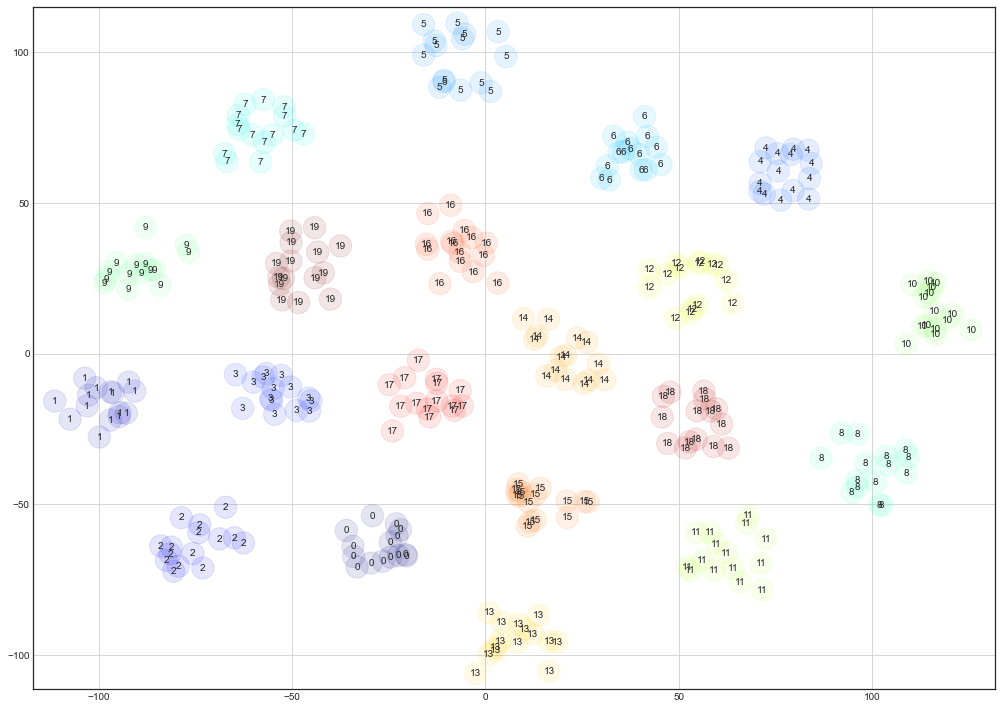

In [12]:
p2vmap.plot_tsne(tsne_map_xy, plotlabels=True, scatter=10)

<br>
<br>

## Data streamer

### Data

In [13]:
baskets_2 = baskets.copy()
baskets_2 = baskets_2.head(1_000)
baskets_2 = baskets_2[baskets_2.groupby("basket")["product"].transform("nunique") > 2]
baskets_2.head()

,customer,product,basket
0,0,51,00000000
1,0,113,00000000
2,0,154,00000000
3,0,165,00000000
4,0,185,00000000


In [14]:
baskets_2[baskets_2["basket"] == "00000000"]

,customer,product,basket
0,0,51,00000000
1,0,113,00000000
2,0,154,00000000
3,0,165,00000000
4,0,185,00000000
5,0,253,00000000
6,0,266,00000000


### Initialize streamer

In [15]:
data_stream_p2v = p2vmap.DataStreamP2V(
    data=baskets_2,
    variable_basket="basket",
    variable_product="product",
    batch_size=4,
    shuffle=False,
    n_negative_samples=4,
)

### Generate one batch

In [16]:
center_products, context_products, negative_samples = data_stream_p2v.generate_batch()

In [17]:
center_products

array([51, 51, 51, 51])

In [18]:
context_products

array([113, 154, 165, 185])

In [19]:
negative_samples

array([[142,  55, 263,  36],
       [ 31,  37,  62, 236],
       [114,  38, 226, 119],
       [158,  71, 190,  17]], dtype=int32)

<br>
<br>

## PyTorch

In [20]:
def build_data_loader(streamer, config):
    # build numpy arrays for full dataset
    streamer.reset_iterator()
    list_ce = []
    list_co = []
    list_ns = []
    while True:
        try:
            ce, co, ns = streamer.generate_batch()
            list_ce.append(ce)
            list_co.append(co)
            list_ns.append(ns)
        except:
            break
    ce = np.hstack(list_ce)
    co = np.hstack(list_co)
    ns = np.vstack(list_ns)

    # train/validation split
    ce_t, ce_v, co_t, co_v, ns_t, ns_v = sklearn.model_selection.train_test_split(
        ce, co, ns, **config["split"]
    )

    # build data loader
    dl_train = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(
            torch.LongTensor(ce_t),
            torch.LongTensor(co_t),
            torch.LongTensor(ns_t),
        ),
        **config["train"],
    )
    dl_val = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(
            torch.LongTensor(ce_v),
            torch.LongTensor(co_v),
            torch.LongTensor(ns_v),
        ),
        **config["valid"],
    )
    return dl_train, dl_val

In [21]:
dl_train, dl_validation = build_data_loader(
    streamer=data_stream_p2v,
    config=config_p2vmap["data"],
)

In [22]:
n_products = 300
size = 20
n_negative_samples = 5
batch_size = 8

In [23]:
wi = torch.nn.Embedding(n_products, size, sparse=True)
with torch.no_grad():
    wi.weight.uniform_(-0.025, 0.025)

wo = torch.nn.Embedding(n_products, size, sparse=True)
with torch.no_grad():
    wo.weight.uniform_(-0.025, 0.025)

In [24]:
for ce, co, ns in dl_train:
    ce, co, ns

In [25]:
ce, co, ns

(tensor([ 35, 237,  51,  ..., 122,  18, 130]),
 tensor([ 47, 164,  88,  ..., 141, 295, 284]),
 tensor([[200, 175, 269,  46],
         [287, 221, 239,  71],
         [138, 299,  14, 134],
         ...,
         [166, 117, 122, 177],
         [170, 255, 204,  82],
         [ 43, 139, 106, 111]]))

In [26]:
# embed products (center, context, negative_samples)
wi_center = wi(ce)
wo_positive_samples = wo(co)
wo_negative_samples = wo(ns)

In [27]:
# logits
logits_positive_samples = torch.einsum("ij,ij->i", (wi_center, wo_positive_samples))
logits_negative_samples = torch.einsum("ik,ijk->ij", (wi_center, wo_negative_samples))

In [28]:
# loss
loss_positive_samples = torch.nn.functional.binary_cross_entropy_with_logits(
    input=logits_positive_samples,
    target=torch.ones_like(logits_positive_samples),
    reduction="sum",
)
loss_positive_samples

tensor(709.7704, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)

In [29]:
loss_negative_samples = torch.nn.functional.binary_cross_entropy_with_logits(
    input=logits_negative_samples,
    target=torch.zeros_like(logits_negative_samples),
    reduction="sum",
)
loss_negative_samples

tensor(2839.1475, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)

In [30]:
n_samples = logits_positive_samples.shape[0] * (logits_negative_samples.shape[1] + 1)
n_samples

5120

In [31]:
(loss_positive_samples + loss_negative_samples) / n_samples

tensor(0.6931, grad_fn=<DivBackward0>)

<br>
<br>

## What's next?

### Build your model class

In [32]:
class P2V(torch.nn.Module):
    def __init__(self, n_products, size, batch_size, n_negative_samples):
        super().__init__()

        # add trainable variables here

    def forward(self, center, context, negative_samples):
        None

        # add forward pass here

### Build your trainer class

In [33]:
class TrainerP2V:
    def __init__(self, model, train, validation, path, n_batch_log=500):
        self.model = model
        self.train = train
        self.validation = validation
        self.optimizer = torch.optim.SparseAdam(params=list(model.parameters()))
        self.path = path
        os.makedirs(f"{path}/weights")
        self.writer_train = torch.utils.tensorboard.SummaryWriter(
            f"{self.path}/runs/train"
        )
        self.writer_val = torch.utils.tensorboard.SummaryWriter(f"{self.path}/runs/val")
        self.n_batch_log = n_batch_log
        self.global_batch = 0
        self.epoch = 0
        self.batch = 0

    def fit(self, n_epochs):

        for _ in range(n_epochs):
            print(f"epoch = {self.epoch}")

            for ce, co, ns in self.train:
                self.batch += 1
                self.global_batch += 1

                # add training steps here:
                # - reset gradients
                # - model pass
                # - compute gradients
                # - optimizer step

                self.writer_train.add_scalar("loss", loss_train, self.global_batch)

                if self.batch % self.n_batch_log == 1:
                    self._callback_batch()

            self._callback_epoch()
            self.epoch += 1

        self.writer_train.flush()
        self.writer_train.close()
        self.writer_val.flush()
        self.writer_val.close()

    def _callback_batch(self):
        # validation loss
        self.model.eval()
        with torch.no_grad():
            list_loss_validation = []
            for ce, co, ns in self.validation:
                list_loss_validation.append(self.model(ce, co, ns).item())
            loss_validation = np.mean(list_loss_validation)
        self.writer_val.add_scalar("loss", loss_validation, self.global_batch)
        self.model.train()

        # save weights
        np.save(
            f"{self.path}/weights/wi_{self.epoch:02d}_{self.batch:06d}.npy",
            self.get_wi(),
        )

        np.save(
            f"{self.path}/weights/wo_{self.epoch:02d}_{self.batch:06d}.npy",
            self.get_wo(),
        )

    def get_wi(self):
        return self.model.wi.weight.detach().numpy()

    def get_wo(self):
        return self.model.wo.weight.detach().numpy()

<br>
<br>
&mdash; <br>
Sebastian Gabel <br>
`Learning from Big Data`, Module 3, Extra Tutorial <br>
2021/22 <br>